# Cō Vidis?

**Cō Vidis?** [kʷoː ˈwɪːdɪs] ➡️ latin for "COVID-19, where are you going?"<br/>
(https://en.wikipedia.org/wiki/Quo_vadis)

A Dashboard to follow the state of the Coronavirus with a focus on Switzerland 🇨🇭.

The data source is checked at 6:00, 12:00 and 18:00 GMT+1 (Swiss time).

- **Author** : Fred Montet (https://twitter.com/fredmontet)
- **Repository** : https://github.com/fredmontet/co-vidis
- **Data Source** : https://github.com/CSSEGISandData/COVID-19

---


## Imports

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
sns.set(style="whitegrid")
%config InlineBackend.figure_format ='retina'

# The command to generate the HTML
# jupyter nbconvert covid-19.ipynb --TagRemovePreprocessor.remove_cell_tags='{"remove_cell"}' --TagRemovePreprocessor.remove_input_tags='{"remove_input"}'

## Functions

In [2]:
def create_by_country_dataframe(df):
    by_country = df.T
    by_country.columns = by_country.loc["Country/Region"]
    by_country = by_country[4:]
    by_country = by_country.groupby(axis=1, by=by_country.columns).sum()
    by_country.index = pd.to_datetime(by_country.index)
    return by_country

def is_it_spreading(df):
    return df.diff()

## Data Loading

In [3]:
data = "../data/raw/COVID-19-master/csse_covid_19_data/csse_covid_19_time_series/"

In [4]:
confirmed = f"{data}time_series_19-covid-Confirmed.csv"
deaths = f"{data}time_series_19-covid-Deaths.csv"
recovered = f"{data}time_series_19-covid-Recovered.csv"

In [5]:
df_confirmed = pd.read_csv(confirmed)
df_deaths = pd.read_csv(deaths)
df_recovered = pd.read_csv(recovered)

In [6]:
df = {
    "confirmed": df_confirmed,
    "deaths": df_deaths,
    "recovered": df_recovered
}

## Compute a Index by Country

In [7]:
by_country = {
    "confirmed" : create_by_country_dataframe(df.get("confirmed")),
    "deaths" : create_by_country_dataframe(df.get("deaths")),
    "recovered" : create_by_country_dataframe(df.get("recovered"))
}

Compute the existing cases and add them to the Dictionnary

In [8]:
# Active cases = total confirmed - total recovered - total deaths
by_country["existing"] = by_country["confirmed"] - by_country["recovered"] - by_country["deaths"]

## Regions of Interest

In [9]:
CH = ["Switzerland"]
CH_neighbors = ["Italy", "France", "Liechtenstein", "Austria", "Germany"]
CH_neighbors_no_italy = ["France", "Liechtenstein", "Austria", "Germany"]

# Bulgaria, Cyprus and Romania are not in the list
# Switzerland has been added
EU = ["Switzerland","Austria","Belgium","Croatia","Denmark","Estonia","Finland","France","Germany","Greece","Hungary","Ireland","Italy","Latvia","Lithuania","Luxembourg","Malta","Netherlands","Poland","Portugal","Romania","Slovakia","Slovenia","Spain","Sweden"]
EU_no_italy = ["Switzerland","Austria","Belgium","Croatia","Denmark","Estonia","Finland","France","Germany","Greece","Hungary","Ireland","Latvia","Lithuania","Luxembourg","Malta","Netherlands","Poland","Portugal","Romania","Slovakia","Slovenia","Spain","Sweden"]

## Period of Interest

In [10]:
last_n_days = 14

In [11]:
existing = by_country.get("existing")[-last_n_days:]
confirmed = by_country.get("confirmed")[-last_n_days:]
deaths = by_country.get("deaths")[-last_n_days:]
recovered = by_country.get("recovered")[-last_n_days:]

## Evolution of the Number of Existing Cases

In [12]:
df = by_country.get("existing")[CH].sum(axis=1)

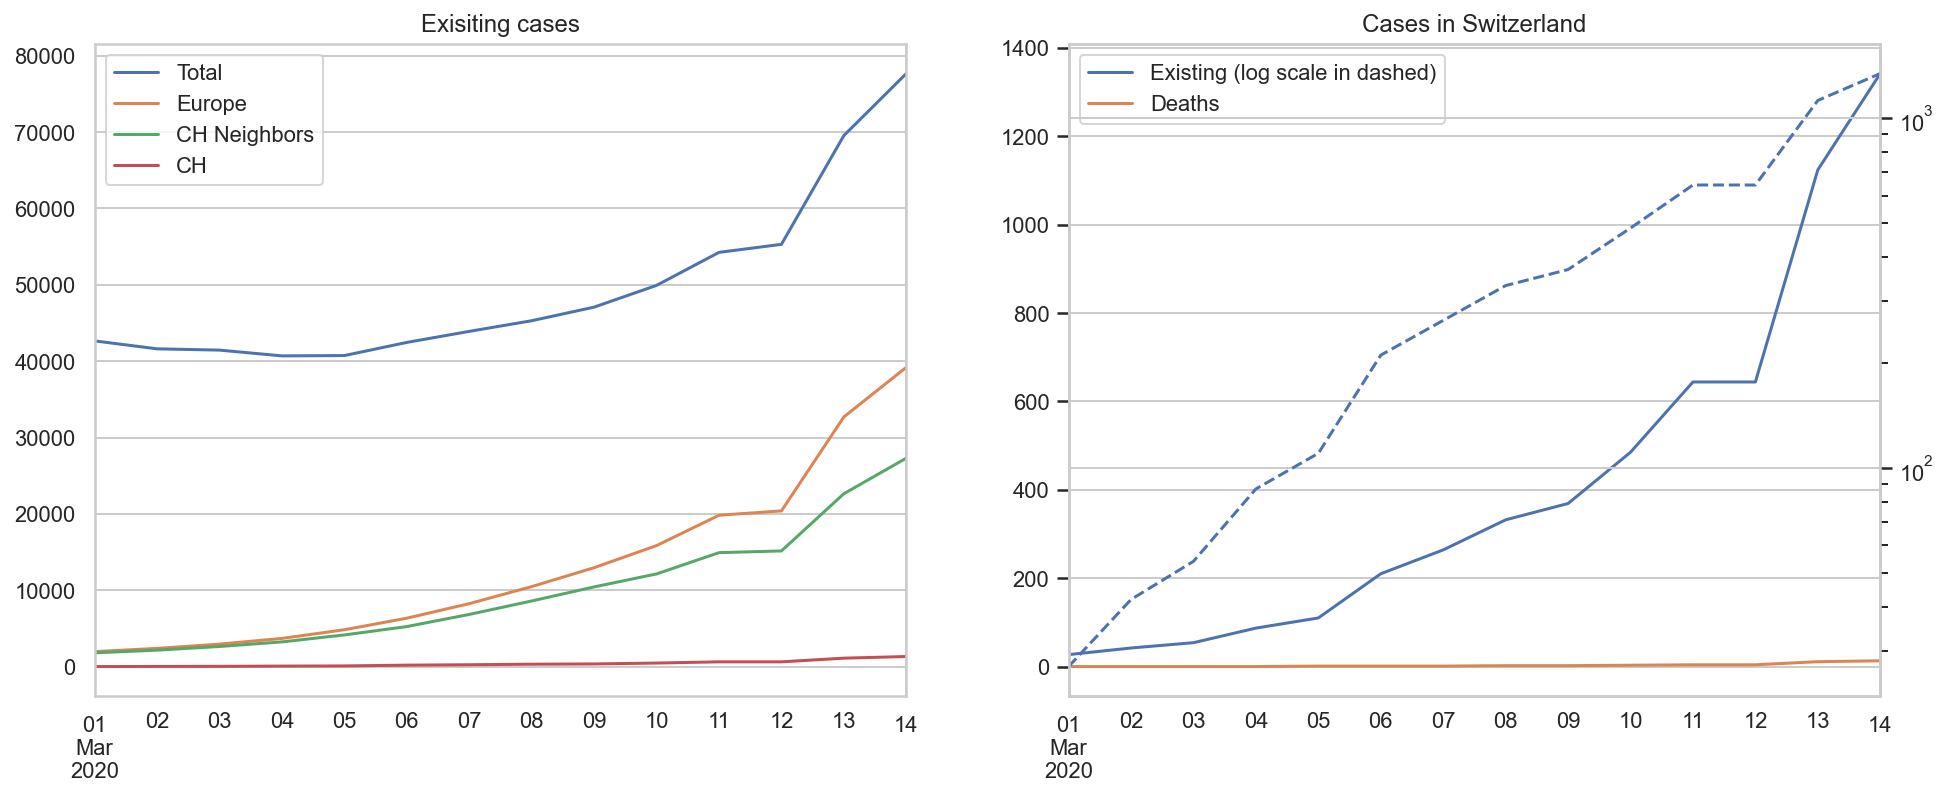

In [13]:
fig, (ax1, ax2) = plt.subplots(1,2)
existing.sum(axis=1).plot(ax=ax1, figsize=(16,6), title="Exisiting cases")
existing[EU].sum(axis=1).plot(ax=ax1)
existing[CH_neighbors].sum(axis=1).plot(ax=ax1)
existing[CH].sum(axis=1).plot(ax=ax1)


ax2 = existing[CH].sum(axis=1).plot(ax=ax2, title="Cases in Switzerland", legend="Existing")
ax2 = deaths[CH].sum(axis=1).plot(ax=ax2)
ax3 = ax2.twinx()
ax3 = existing[CH].sum(axis=1).plot(ax=ax3, logy=True, style="--")

ax1.legend(["Total", "Europe", "CH Neighbors", "CH"]);
ax2.legend(["Existing (log scale in dashed)", "Deaths"]);

## Cases Around and with Switzerland

In [14]:
df1 = pd.DataFrame(by_country["existing"][CH_neighbors + CH].iloc[-1].astype(int))
df2 = pd.DataFrame(by_country["deaths"][CH_neighbors + CH].iloc[-1].astype(int))
df1.rename(columns={df1.columns[-1]:"Existing"}, inplace=True)
df2.rename(columns={df2.columns[-1]:"Deaths"}, inplace=True)
df = pd.concat([df1,df2], axis=1)

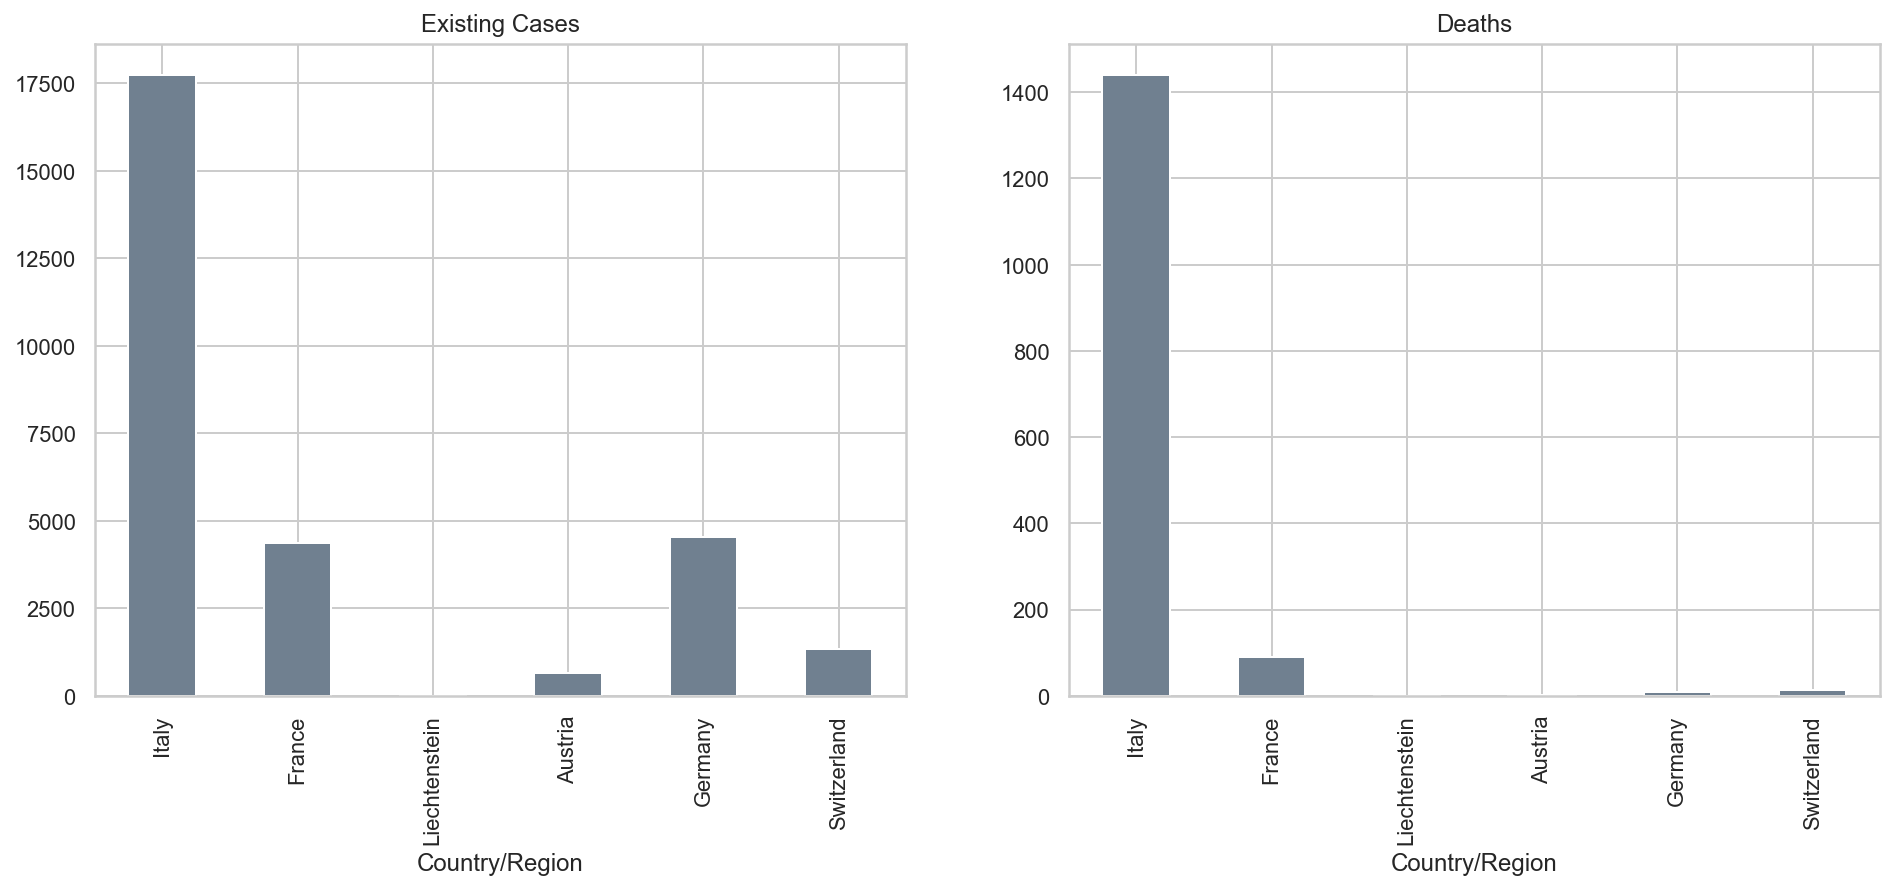

In [15]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.grid(True)
df.Existing.plot.bar(title="Existing Cases", figsize=(16,6), color="slategray", ax=ax1);
df.Deaths.plot.bar(title="Deaths", figsize=(16,6), color="slategray", ax=ax2);

In [16]:
df.sort_values(by="Existing")

,Existing,Deaths
Country/Region,,
Liechtenstein,4,0
Austria,648,1
Switzerland,1342,13
France,4377,91
Germany,4530,9
Italy,17750,1441


## New Cases per Day

In [17]:
# Linear Regression
df = existing[CH].diff()[1:]
X = df.index.factorize()[0].reshape(-1,1)
Y = df.values
m = LinearRegression().fit(X, Y)
Y_pred = m.predict(X)
Y_pred = pd.DataFrame(Y_pred)
Y_pred.index = df.index
Y_pred = Y_pred.rename(columns={0:"Trend"})

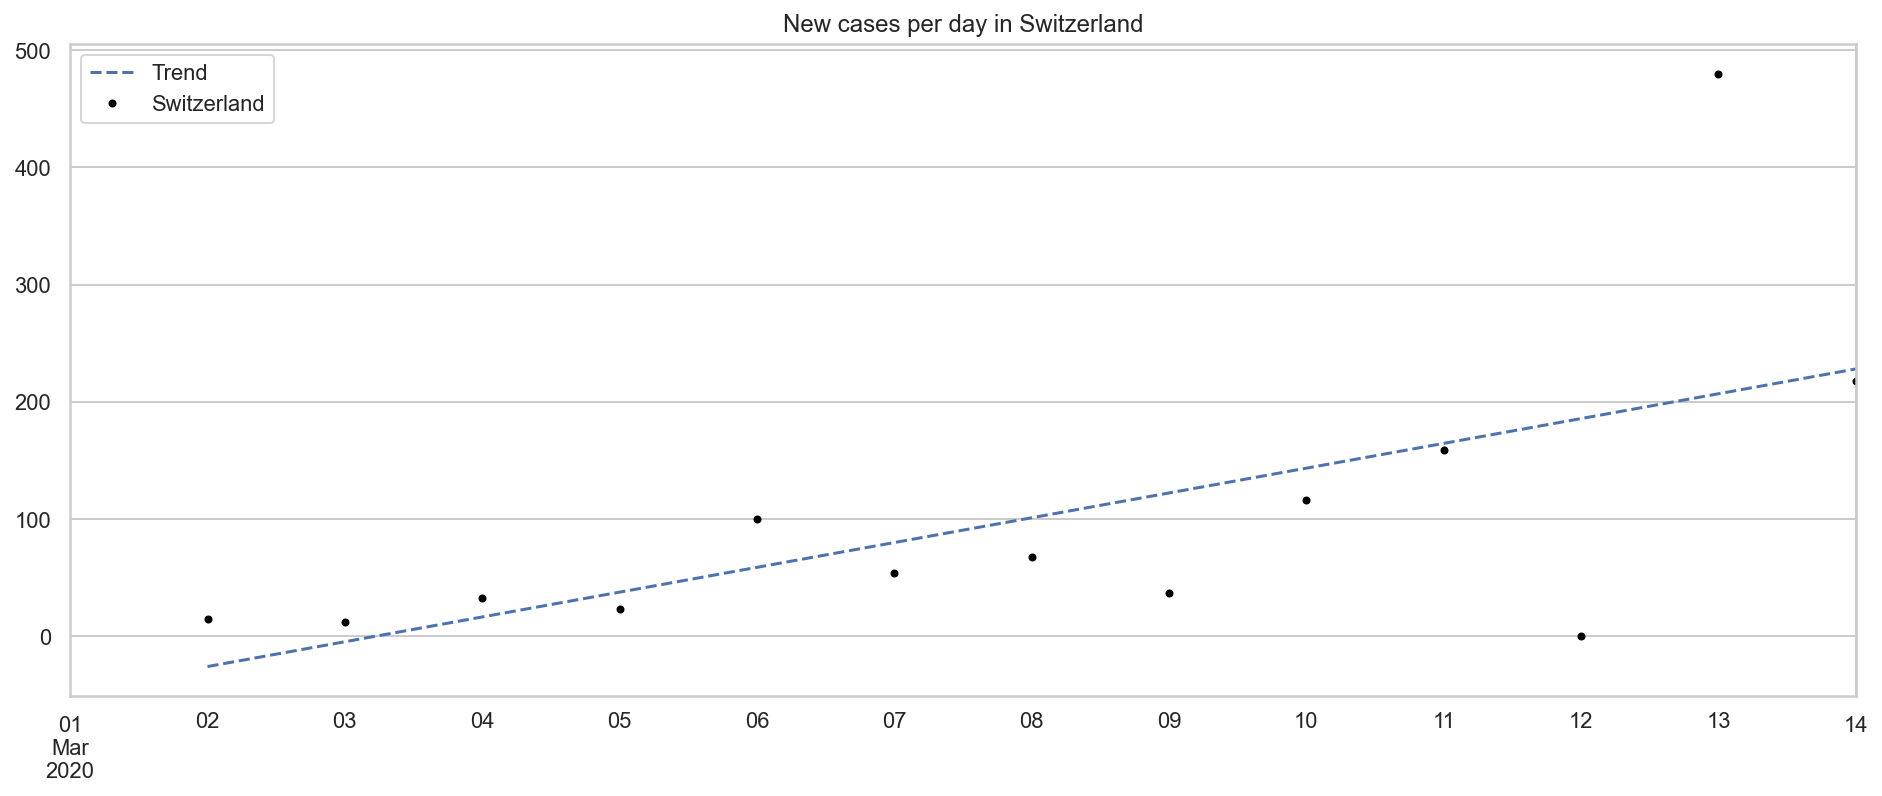

In [18]:
fig, ax = plt.subplots()

Y_pred.plot(ax=ax, figsize=(16,6), style="--", title="New cases per day in Switzerland");
existing[CH].diff().plot(ax=ax, style=".", color="black", title="New cases per day in Switzerland");

ax.legend(["Trend", "Switzerland"]);

---

In [19]:
print(f"last available data : {by_country['existing'].iloc[-1].name.date()}")

last available data : 2020-03-14
